# NCorr-FP: POC & analysis

Neighbourhood-based fingerprinting for correlated data is a method of embedding a traceable mark into the tabular data and is unlike its predecessors data driven, meaning that it preserves the existing stats of the data.

This notebook represents the proof-of-concept and preliminary analysis of the method, its effectiveness, fidelity, robustness and effects on data utility. 

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
import sys
import os

In [10]:
# Include properly the project root into the path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [11]:
from NCorrFP.ncorr import *
from NCorrFP.analysis.NCorr_FP_plot import *
#from datasets import Dataset, Adult

In [12]:
markers = ['o', 'v', 'x', 's', "^", "*", "P", "1", "X", "p", "D"]

## Table of Contents
- [1. Effectiveness](#1.-Effectiveness)
    - [1.1 Vote errors (VER)](#1.1-Vote-errors-(VER))
    - [1.2 Fingerprint detection confidence (DC)](#2.-Fingerprint-bit-errors-(Correct-fingerprint-confidence))
    - [1.3 False accusation confidence (FAC)](#3.-False-accusation-confidence-(FAC))
- [2. Fidelity](#2.-Fidelity)
    - [2.1 Univariate]()
    - [2.2 Bi-variate statistics (pairwise histograms, correlations, ..)](#2.-Bivariate-(pairwise-correlations))
- [3. Robustness](#3.-Robustness)
    - [3.1 Collusion attack](#3.1.-Collusions)
    - [3.2 Single-user attacks](#3.2.-Single-user-attacks)
        - [3.2.1 Horizontal subset attack](#3.2.1-Horizontal-subset)
        - [3.2.2 Vertical subset attack](#3.2.2-Vertical-subset)
        - [3.2.3 Flipping attack](#3.2.3.-Flipping-attack)
        - [3.2.4 Cluster flipping attack](#3.2.4.-Cluster-flipping-attack)
- [4. Utility](#4.-Utility)

## 1. Effectiveness

The first requirements of the fingerprinting method is its effectiveness. 
To that end, we measure:
1. Detection vote error rates (VER)
2. Detection confidence (number of bits correctly extracted)
3. Falce accusation confidence 

This depends on the numbed of marked records and neighbourhood size.

In [33]:
results_effectiveness = pd.read_csv('results/effectiveness_adult.csv')
results_effectiveness.head(2)

,gamma,k,fingerprint_length,n_recipients,sk,id,code,embedding_ratio,vote_error,tp,tn
0,2,30,128,20,100,0,tardos,0.5,0.011316,1.0,0.812500
1,2,30,128,20,100,0,tardos,0.5,0.011316,1.0,0.796875


### 1.1 Vote errors (VER)
To recap from the demo, some detection errors are made due to slight shift in data distributions in fingerprinted dataset (depicted in color red in tables from the demo of the detection algorithm).

We here experimentaly quantify these errors depending on neighbourhood size and number of embedded marks.

Hypohteses:
- small neighbourhood size causes more detection errors bacuse the distributions might not be representative; too big neighbourhood might have some computational cost and not presrve the correlations as well
- the more marks embedded, the more errors introduced

In [34]:
# vote errors on forest cover data

# x-axis: gamma
# y-axis: vote error rate
# colors: neighbourhood size
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fixed: fp_length (128), n_recipients (20), recipient_id (0) , code (tardos)

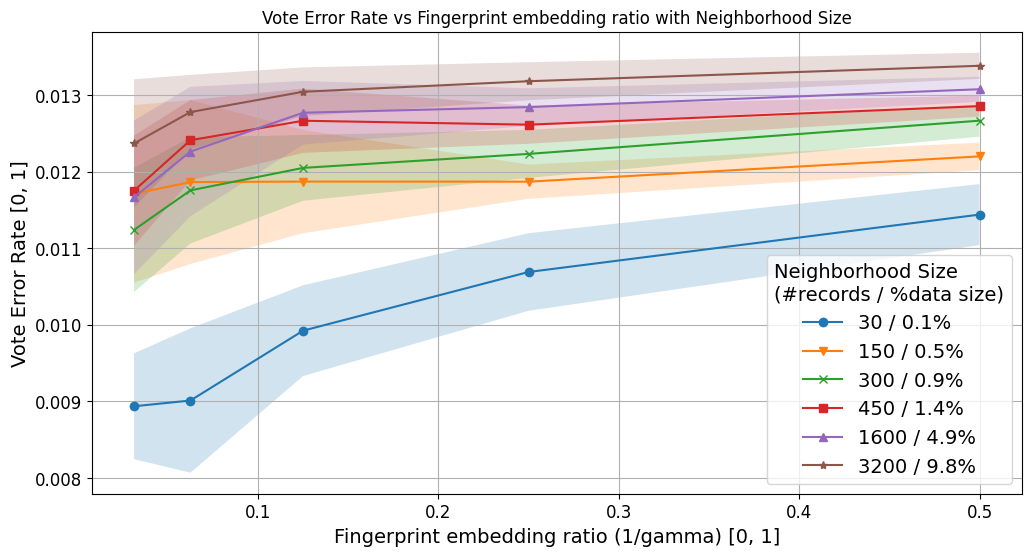

In [35]:
# fixed: fp_length (128), n_recipients (20), recipient_id (0) 
results_effectiveness_ver = results_effectiveness[results_effectiveness["fingerprint_length"]==128]
results_effectiveness_ver = results_effectiveness_ver[results_effectiveness_ver["n_recipients"]==20]
results_effectiveness_ver = results_effectiveness_ver[results_effectiveness_ver["id"]==0]
results_effectiveness_ver = results_effectiveness_ver[results_effectiveness_ver["code"]=='tardos']
results_effectiveness_ver = results_effectiveness_ver[results_effectiveness_ver["k"]!=800]
results_effectiveness_ver = results_effectiveness_ver[results_effectiveness_ver["k"]!=600]


# Generate the plot
plot_vote_error_rate(results_effectiveness_ver, save='../figures/vote_err_ext_tifs.png')

The vote error of around 1.3% in combination with a small standard deviation gives a good confidence that the fingerprint bits are going to be extracted with 100% accuracy.  

### 2. Fingerprint bit errors (Correct fingerprint confidence)

This measure depicts more closely the actual extraction success for the fingerprint. Normally, we would want a 100% extraction ratio, i.e. all bits are correctly extracted, however, a high percentage associated to a fingerprint of one recipient might be indicator enough for the correct recipient, especially if the rate is low for other recipients (i.e. around 50% for random guessing).
The extraction provides a probability vector for each recipient; we measure the probability for the correct fingerprint. In the next point, we look at extraction rate for true negatives.

Hypotheses:
- Fingerprint bit length and number of marks embedded in combination affect the detection success rate. Fingerprints that are long, but embeddedd with a low number of marks may have a low extraction success because some bits might not be embedded at all (they are chosen randomly). 

Experiment:
- 10 fingerprint embeddings
- 10 different gammas (fp embedding ratios)
- 3 different fingerprint lengths

In [36]:
# fingerprint bit errors (correct fingerprint confidence)

# x-axis: gamma
# y-axis: correct fingerprint confidence
# color: fingerprint lenght
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fixed: k (300), n_recipients (20), recipient_id (0) 

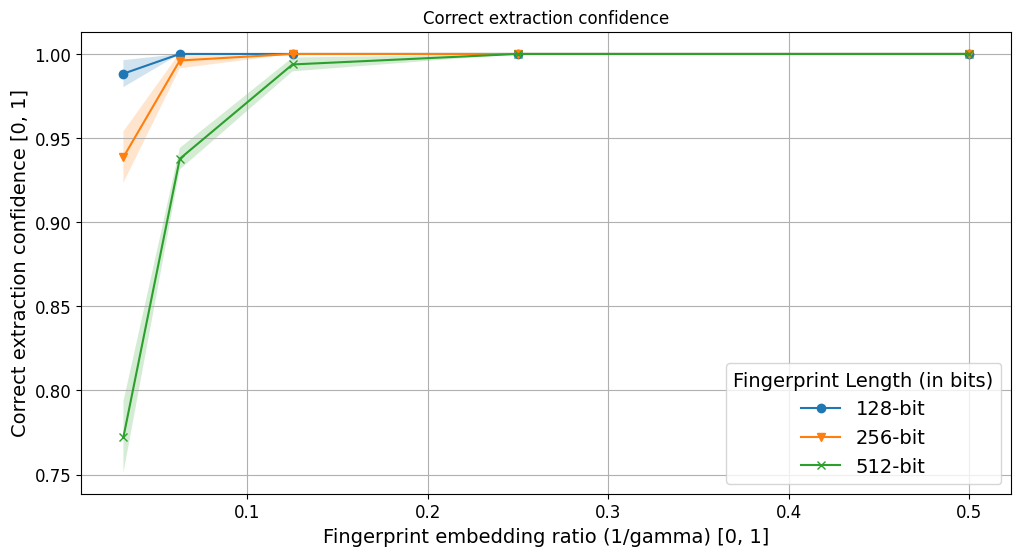

In [37]:
# fixed: k (300), n_recipients (20), recipient_id (0) , code (tardos)
results_effectiveness_tp = results_effectiveness[results_effectiveness["k"]==300]
results_effectiveness_tp = results_effectiveness_tp[results_effectiveness_tp["n_recipients"]==20]
results_effectiveness_tp = results_effectiveness_tp[results_effectiveness_tp["id"]==0]
results_effectiveness_tp = results_effectiveness_tp[results_effectiveness_tp["code"]=='tardos']

plot_tp_confidence(results_effectiveness_tp)

Referring to the hypothesis: the extraction confidence indeed drops lower for longer fingerprints at low embedding ratios. 

### 3. False accusation confidence (FAC)

Here we look at how the probabilities look like for wrong recipients. In every fingerprint detection, the algorithm outputs confidences for all recipients. In ideal scenario, the confidence of the correct recipient is 1.0 (i.e. perfect bit-wise matching of a detected fingerprint to the fingerprint of the correct recipient), and the confidences of all other recipients are around 0.5, in line with random guessing of the bit-sequence.

Experiment (same as above):
- fixed: 10 recipients
- 20 fingerprint embeddings
- 10 different gammas
- 3 different fingerprint lengths

In [38]:
# true negatives confidence

# x-axis: gamma 
# y-axis: false fingerprint confidence (this is the confidence that gets assigned to the wrong recipient)
# z-axis: tardos, hash
# color: fingerprint lenght
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fixed: k (300), n_recipients (20), recipient_id (0) 

In [39]:
results_effectiveness_tn = results_effectiveness[results_effectiveness["k"]==300]
results_effectiveness_tn = results_effectiveness_tn[results_effectiveness_tn["n_recipients"]==20]
results_effectiveness_tn = results_effectiveness_tn[results_effectiveness_tn["id"]==0]

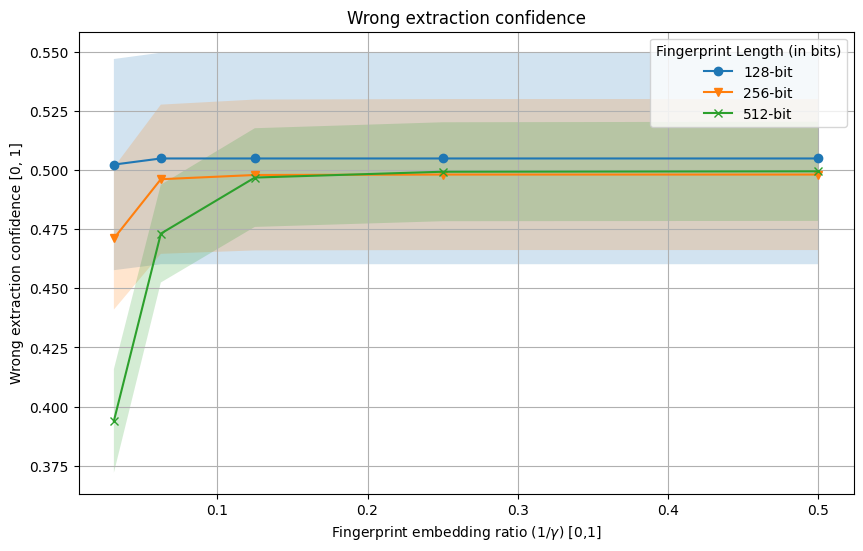

In [40]:
plot_tn_confidence(results_effectiveness_tn[results_effectiveness_tn['code']=='hash'])

Naturally, the standard deviation for the confidences of shorter fingerprints are larger, however the overall average is around 50% in line with the hypothesis. It means that the wrong recipient will match the extracted fingerprint with around 50% bits which is equivalent to random guessing and insignificant for accusation. 



**Tardos codes** are constructed differently, where fingerprints by design have a certain overlap. Unlike a hash fingerprint where each bit has independednt probability of selection 50/50, tardos codes share common bit-wise probabilities. The confidences in wrong fingerprints (by exact matching) are therefore somewhat higher for Tardos:

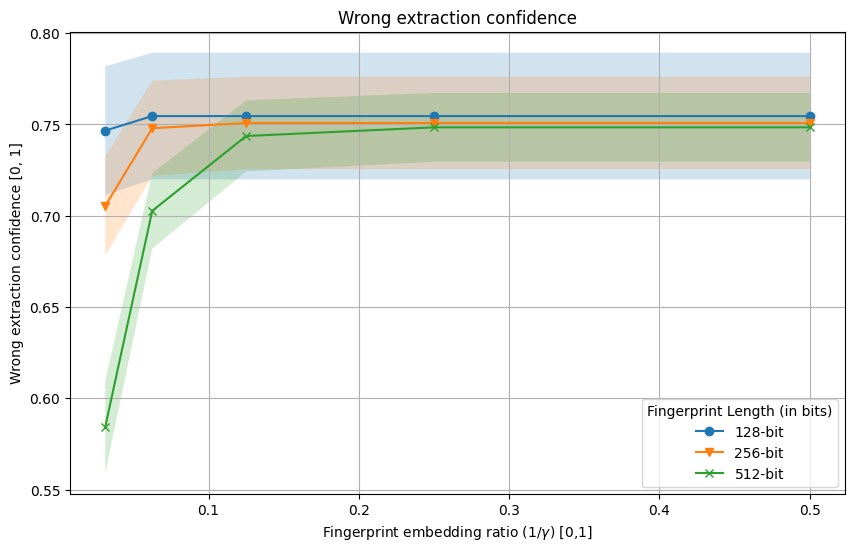

In [41]:
plot_tn_confidence(results_effectiveness_tn[results_effectiveness_tn['code']=='tardos'])

**Summary:** For clearer view we merge true positive confidences, and true negative (seeing distinctive difference between hash and tardos codes):

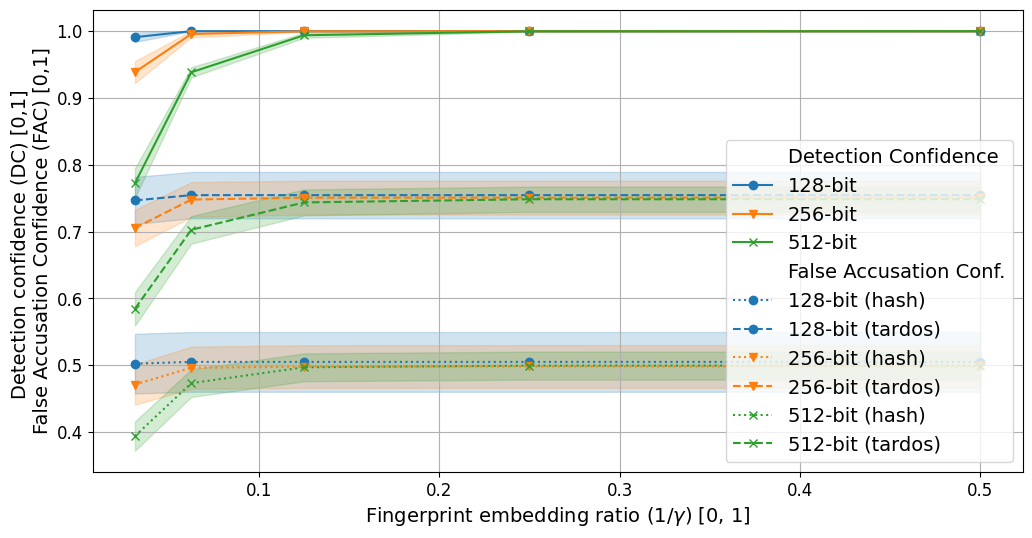

In [42]:
plot_tp_tn_confidence(results_effectiveness_tn, save="../figures/effectiveness_tifs.png")

## 2. Fidelity 

The second requirement is fidelity, i.e. how preserved the data is. 

0. Accuracy (number of preserved values)
1. Univariate statistics
2. Bi-variate stats

We take two angles: 
- Fidelity overall, to measure how the scheme preserves the data quality overall by changing the seed for the experiments (owner's secret key). 
- Stability of the fidelity: How mutually different the datasets are between different recipients? For this we compare the datasets originating from the same secret key -- this simulates the instance of the fingerprint usage, where the owner embedds their fingerprint and distributes the datasets.

In [43]:
results_fidelity = pd.read_csv('results/fidelity_univariate_adult.csv')
results_fidelity.head(2)

,gamma,k,fingerprint_length,n_recipients,sk,id,code,embedding_ratio,recipient_id,attribute,rel_delta_mean,rel_delta_std,hellinger_distance,kl_divergence,emd,ks,p_value
0,2,300,128,20,100,0,tardos,0.5,0,age,0.000543,0.001205,0.001986,0.000016,0.040877,0.001935,1.0
1,2,300,128,20,100,0,tardos,0.5,0,workclass,NaN,NaN,0.005434,0.000118,12.424434,NaN,NaN


In [44]:
results_fidelity_bivar = pd.read_csv('results/fidelity_bivariate_adult.csv')
results_fidelity_bivar.head(2)

,gamma,k,fingerprint_length,n_recipients,sk,id,code,embedding_ratio,recipient_id,accuracy,marital-status-relationship,marital-status-sex,relationship-sex,income-relationship,education-education-num,age-marital-status,education-num-occupation,age-relationship,age-sex
0,2,300,128,20,100,0,tardos,0.5,0,0.018812,0.019918,0.003347,0.018347,0.059507,0.001086,0.053191,0.010132,0.087056,0.010990
1,2,300,128,20,100,1,tardos,0.5,1,0.018834,0.019463,0.002507,0.017718,0.057474,0.001209,0.053238,0.009727,0.086239,0.076151


### 2.1 Univariate - dataset accuracy, delta mean & std

In [45]:
# dataset accuracy 

# x-axis: gamma 
# y-axis: accuracy (1 - % changed values)  - expected: <= embedding_ratio/n_columns
# color: k (neighbourhood size)
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fixed: n_recipients (20), recipient_id (0), fp_length (128) , code (tardos)

In [47]:
# fixed: n_recipients (20), recipient_id (0), fp_length (128) 
results_fidelity_bivar_acc = results_fidelity_bivar[results_fidelity_bivar['n_recipients']==20]
results_fidelity_bivar_acc = results_fidelity_bivar_acc[results_fidelity_bivar_acc['recipient_id']==0]
results_fidelity_bivar_acc = results_fidelity_bivar_acc[results_fidelity_bivar_acc['fingerprint_length']==128]
results_fidelity_bivar_acc = results_fidelity_bivar_acc[results_fidelity_bivar_acc['code']=='tardos']

We can observe the expected linear behaviour of dataset accuracy depending on fingerprint embedding ratio. 
The neighbourhood size does not seem to affect the accuracy.

In [48]:
accuracy_ncorr = results_fidelity_bivar_acc.groupby(['gamma'])['accuracy'].aggregate(['mean', 'std']).reset_index()
accuracy_ncorr['mean'] = 1 - accuracy_ncorr['mean']
#accuracy_ncorr

In [49]:
# accuracy from random fingerprinting
results_fidelity_baseline = pd.read_csv('results/fidelity-baseline_bivariate_adult.csv')
#results_fidelity_baseline.head(2)

In [50]:
accuracy_baseline = results_fidelity_baseline.groupby(['g'])['accuracy'].aggregate(['mean', 'std']).reset_index()
accuracy_baseline['mean'] = 1 - accuracy_baseline['mean']
#accuracy_baseline

In [51]:
# TIFS: Table 2
accuracy = accuracy_ncorr
accuracy = accuracy.rename(columns={'mean': 'mean_ncorr', 'std': 'std_ncorr'})
accuracy['baseline_mean'] = accuracy_baseline['mean']
accuracy['baseline_std'] = accuracy_baseline['std'] 
accuracy['low_bound_mean'] = 1 - 1 / (15 * accuracy['gamma'])
accuracy

,gamma,mean_ncorr,std_ncorr,baseline_mean,baseline_std,low_bound_mean
0,2,0.980832,0.000315,0.977032,0.000106,0.966667
1,4,0.990471,0.000160,0.988462,0.000168,0.983333
2,8,0.995268,0.000096,0.994246,0.000094,0.991667
3,16,0.997628,0.000048,0.997110,0.000066,0.995833
4,32,0.998853,0.000023,0.998560,0.000043,0.997917


### Fidelity: Hellinger distance

In [52]:
results_fidelity.head(10)

,gamma,k,fingerprint_length,n_recipients,sk,id,code,embedding_ratio,recipient_id,attribute,rel_delta_mean,rel_delta_std,hellinger_distance,kl_divergence,emd,ks,p_value
0,2,300,128,20,100,0,tardos,0.5,0,age,0.000543,0.001205,0.001986,0.000016,0.040877,0.001935,1.000000
1,2,300,128,20,100,0,tardos,0.5,0,workclass,NaN,NaN,0.005434,0.000118,12.424434,NaN,NaN
2,2,300,128,20,100,0,tardos,0.5,0,fnlwgt,0.000187,0.000756,0.005599,0.000114,514.149719,0.002518,0.999945
3,2,300,128,20,100,0,tardos,0.5,0,education,NaN,NaN,0.000969,0.000004,20.154602,NaN,NaN
4,2,300,128,20,100,0,tardos,0.5,0,education-num,0.000043,0.000368,0.000514,0.000001,0.000645,0.000123,1.000000
5,2,300,128,20,100,0,tardos,0.5,0,marital-status,NaN,NaN,0.024301,0.001845,8.427935,NaN,NaN
6,2,300,128,20,100,0,tardos,0.5,0,occupation,NaN,NaN,0.004247,0.000072,11.519241,NaN,NaN
7,2,300,128,20,100,0,tardos,0.5,0,relationship,NaN,NaN,0.007914,0.000248,5.064095,NaN,NaN
8,2,300,128,20,100,0,tardos,0.5,0,race,NaN,NaN,0.012193,0.000588,7.102485,NaN,NaN
9,2,300,128,20,100,0,tardos,0.5,0,sex,NaN,NaN,0.001247,0.000006,0.683456,NaN,NaN


In [53]:
# showinng diff in mean and std only for numerical attributes
results_fidelity_num = results_fidelity[~results_fidelity["attribute"].isin(["Id"])]
# fix: k (300), n_recipients (20), recipient_id (0), fp_length (128) 
#results_fidelity_num = results_fidelity_num[results_fidelity_num["k"]==300]
results_fidelity_num = results_fidelity_num[results_fidelity_num["recipient_id"]==0]
results_fidelity_num = results_fidelity_num[results_fidelity_num["n_recipients"]==20]
results_fidelity_num = results_fidelity_num[results_fidelity_num["fingerprint_length"]==128]
results_fidelity_num = results_fidelity_num[results_fidelity_num["sk"]==100]

In [54]:
results_fidelity_num.head()

,gamma,k,fingerprint_length,n_recipients,sk,id,code,embedding_ratio,recipient_id,attribute,rel_delta_mean,rel_delta_std,hellinger_distance,kl_divergence,emd,ks,p_value
0,2,300,128,20,100,0,tardos,0.5,0,age,0.000543,0.001205,0.001986,0.000016,0.040877,0.001935,1.000000
1,2,300,128,20,100,0,tardos,0.5,0,workclass,NaN,NaN,0.005434,0.000118,12.424434,NaN,NaN
2,2,300,128,20,100,0,tardos,0.5,0,fnlwgt,0.000187,0.000756,0.005599,0.000114,514.149719,0.002518,0.999945
3,2,300,128,20,100,0,tardos,0.5,0,education,NaN,NaN,0.000969,0.000004,20.154602,NaN,NaN
4,2,300,128,20,100,0,tardos,0.5,0,education-num,0.000043,0.000368,0.000514,0.000001,0.000645,0.000123,1.000000


In [55]:
hellinger = results_fidelity_num.groupby(['embedding_ratio', 'attribute', 'k'])['hellinger_distance'].agg(['mean', 'std']).reset_index()
#hellinger.to_csv('hellinger.csv') 
hellinger.head(10)

,embedding_ratio,attribute,k,mean,std
0,0.03125,age,300,0.000469,NaN
1,0.03125,age,450,0.000446,NaN
2,0.03125,capital-gain,300,0.010111,NaN
3,0.03125,capital-gain,450,0.009954,NaN
4,0.03125,capital-loss,300,0.004781,NaN
5,0.03125,capital-loss,450,0.005123,NaN
6,0.03125,education,300,0.000286,NaN
7,0.03125,education,450,0.000334,NaN
8,0.03125,education-num,300,0.000000,NaN
9,0.03125,education-num,450,0.000000,NaN


In [56]:
# baseline
fidelity_baseline = pd.read_csv('results/fidelity-baseline_univariate_adult.csv')

In [57]:
hellinger_baseline = fidelity_baseline.groupby(['embedding_ratio', 'attribute'])['hellinger_distance'].agg(['mean', 'std']).reset_index()
hellinger_baseline.head(10)
#hellinger_baseline.to_csv('hellinger_baseline.csv')

,embedding_ratio,attribute,mean,std
0,0.03125,age,1.490550e-04,4.836137e-05
1,0.03125,capital-gain,4.476688e-07,1.771230e-07
2,0.03125,capital-loss,8.660609e-06,1.691488e-06
3,0.03125,education,1.782541e-03,3.409919e-04
4,0.03125,education-num,1.616750e-03,9.728691e-04
5,0.03125,fnlwgt,2.695814e-08,1.165615e-08
6,0.03125,hours-per-week,3.001230e-04,5.987584e-05
7,0.03125,income,0.000000e+00,0.000000e+00
8,0.03125,marital-status,4.443515e-03,8.322784e-04
9,0.03125,native-country,9.496918e-02,3.478673e-05


## Fidelity: KL divergence

In [58]:
kl_divergence = results_fidelity_num.groupby(['embedding_ratio', 'attribute', 'k'])['kl_divergence'].agg(['mean', 'std']).reset_index()
kl_divergence.to_csv('results/kl_divergence.csv')
kl_divergence.head()

,embedding_ratio,attribute,k,mean,std
0,0.03125,age,300,8.779649e-07,NaN
1,0.03125,age,450,7.929256e-07,NaN
2,0.03125,capital-gain,300,4.042016e-04,NaN
3,0.03125,capital-gain,450,3.903218e-04,NaN
4,0.03125,capital-loss,300,9.059732e-05,NaN


In [59]:
kl_divergence_baseline = fidelity_baseline.groupby(['embedding_ratio', 'attribute'])['kl_divergence'].agg(['mean', 'std']).reset_index()
kl_divergence_baseline.to_csv('results/kl_divergence_baseline.csv')
kl_divergence_baseline.head()

,embedding_ratio,attribute,mean,std
0,0.03125,age,9.732556e-08,5.762349e-08
1,0.03125,capital-gain,9.142862e-13,8.819262e-13
2,0.03125,capital-loss,3.103232e-10,1.249604e-10
3,0.03125,education,1.303105e-05,5.091043e-06
4,0.03125,education-num,8.997527e-06,7.680759e-06


In [60]:
# Relative delta mean per attribute (i.e. normalised by the attribute's values range)

# x-axis: gamma 
# y-axis: relative delta mean value
# color: data attributes (only numerical)
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fix: k (300), n_recipients (20), recipient_id (0), fp_length (128) 

## Fidelity: histogram visual similarity

In [61]:
#data_fp_name = f'adult-fp/adult_gamma{gamma}_k{k}_fingerprint_length64_n_recipients20_sk100_id0_codetardos.csv'
# pd.read_csv(f'adult-fp/adult_gamma2_k300_fingerprint_length128_n_recipients20_sk100_id0_codehash.csv')
datasets = [pd.read_csv(f'fp_datasets/NCorrFP/adult_fp/adult_gamma{gamma}_k300_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv').drop(['Id', 'income'], axis=1)[['age', 'workclass']] for gamma in [32, 16, 8, 4, 2]]
baseline = pd.read_csv('../../datasets/adult_train_id.csv').drop(['Id', 'income'], axis=1)

In [62]:
plot_histogram_grid(datasets, baseline, columns=5, bins=20, save='figures/hist_adult_tifs.png')

TypeError: plot_histogram_grid() got an unexpected keyword argument 'save'

### 2. Bivariate (pairwise correlations)

In [63]:
# insert correlation matrices

# x-axis: gamma (embedding ratio)
# y-axis: k (neighbourhood size)
# fix: n_recipients (20), sk (100), fp_length (64), recipient_id (0)

# todo: update 

In [64]:
# datasets: [original + 5 gammas] * 2 neighbourhood sizes
datasets = []
gammas = [0, 32, 16, 8, 4, 2]
neighs = [300, 450]
for k in neighs:
    original = pd.read_csv('../../datasets/adult_train_id.csv').drop(['Id', 'income'], axis=1)
    datasets.append(original)
    for gamma in gammas[1:]:
        fp = pd.read_csv(f'fp_datasets/NCorrFP/adult_fp/adult_gamma{gamma}_k{k}_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv').drop(['Id', 'income'], axis=1)
        datasets.append(fp)

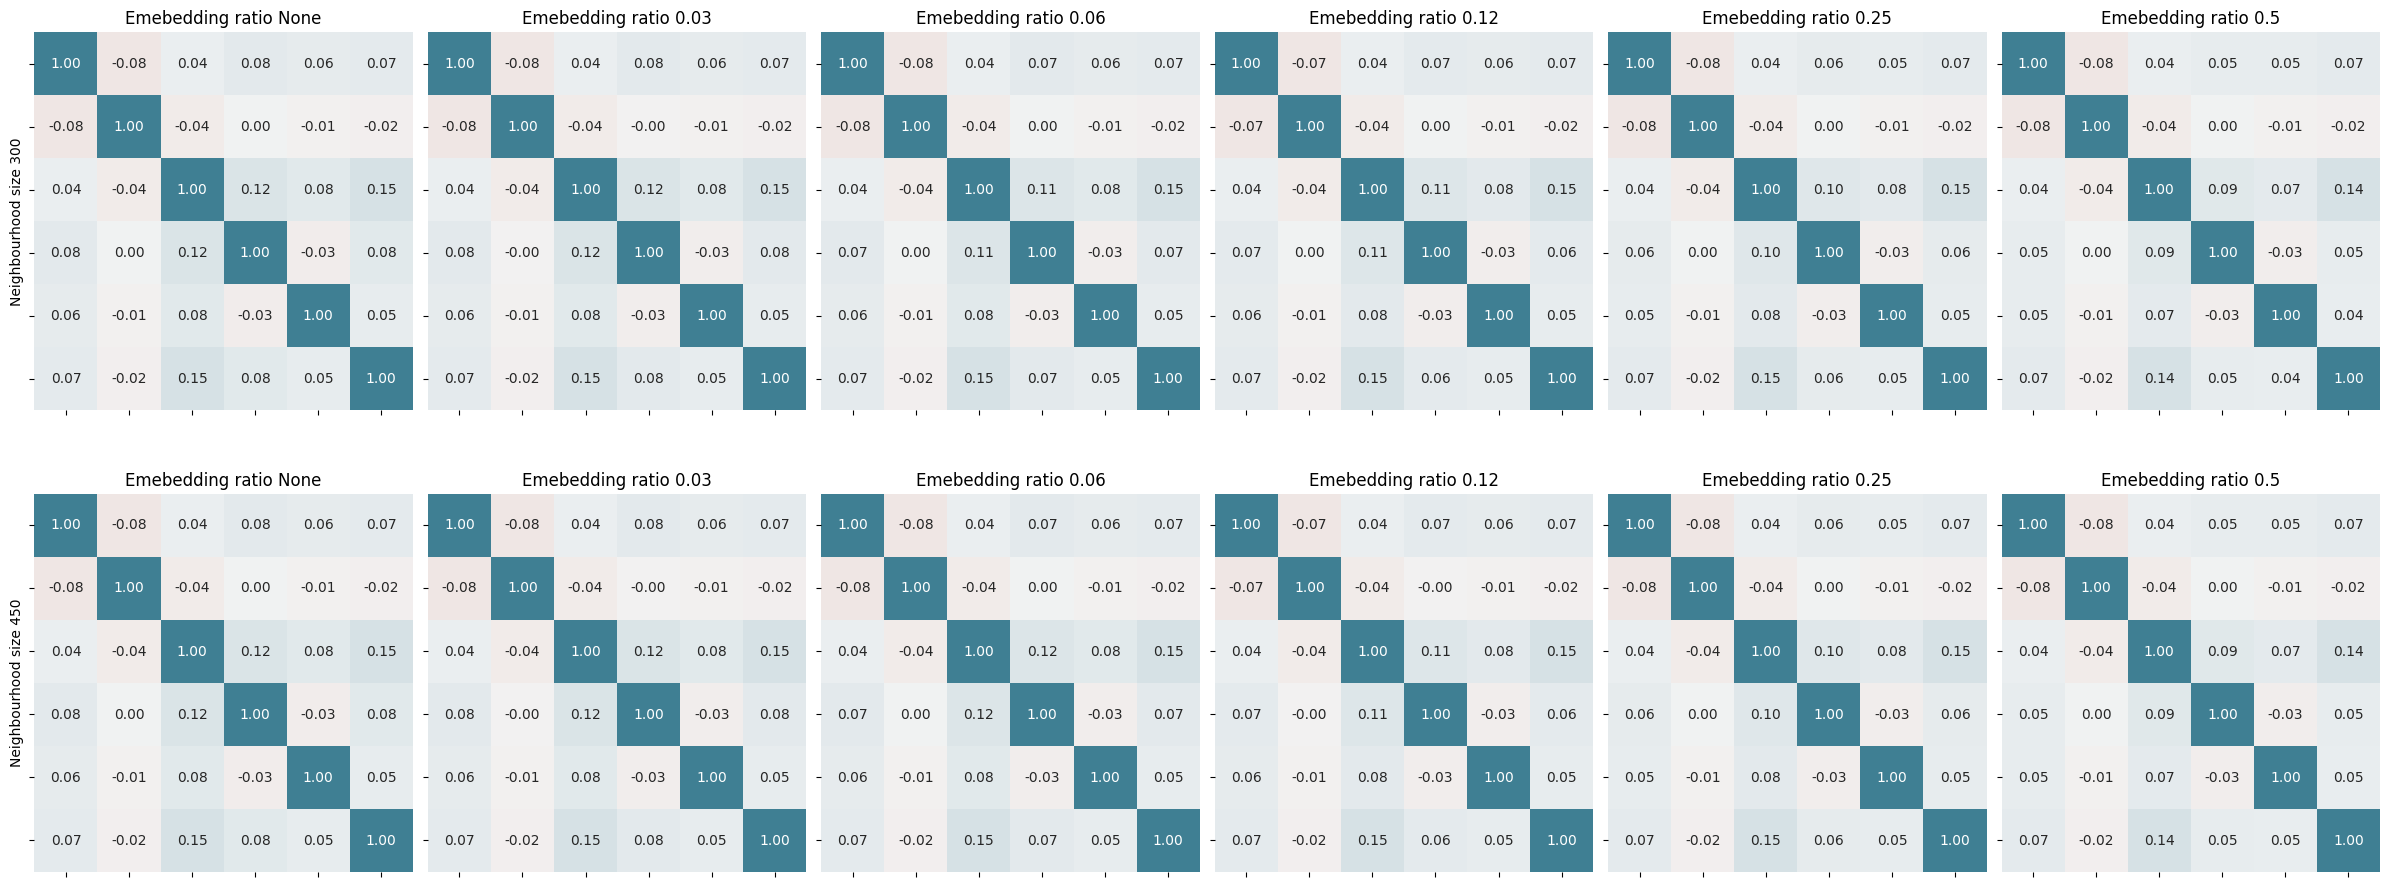

In [65]:
# datasets: (original + 5 fingerprinted) *2 diff neighbourhood sizes
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(24, 10))

# Plotting each correlation matrix in a grid
for i, ax in enumerate(axes.flat):
    sns.heatmap(datasets[i].corr(numeric_only=True), ax=ax, cbar=False, square=True, 
                cmap=sns.diverging_palette(20, 220, as_cmap=True), vmin=-1, vmax=1,  # colors
                annot=True, fmt=".2f") # annotations
    ax.set_title(f"Emebedding ratio {None if gammas[i%len(gammas)]==0 else round(1.0/(gammas[i%len(gammas)]), 2)}")
    #ax.axis('off')  # Optional: turn off axes for a cleaner look
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    if i%len(gammas)==0:
        ax.set_ylabel(f'Neighbourhood size {neighs[int(i/len(gammas))]}')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

None of the numeric attributes are correlated, but we can see that the values stay very similar to the original.

Let's take a look at pairwise histograms.

In [66]:
# randomly fp data
fp_data_rand = pd.read_csv(f'fp_datasets/random/adult_fp/adult_fp_5_random.csv')
fp_data_ncorr_100 = pd.read_csv(f'fp_datasets/NCorrFP/adult_fp/adult_gamma5_k100_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv')
fp_data_ncorr_300 = pd.read_csv(f'fp_datasets/NCorrFP/adult_fp/adult_gamma5_k300_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv')
fp_data_ncorr_450 = pd.read_csv(f'fp_datasets/NCorrFP/adult_fp/adult_gamma5_k450_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv')

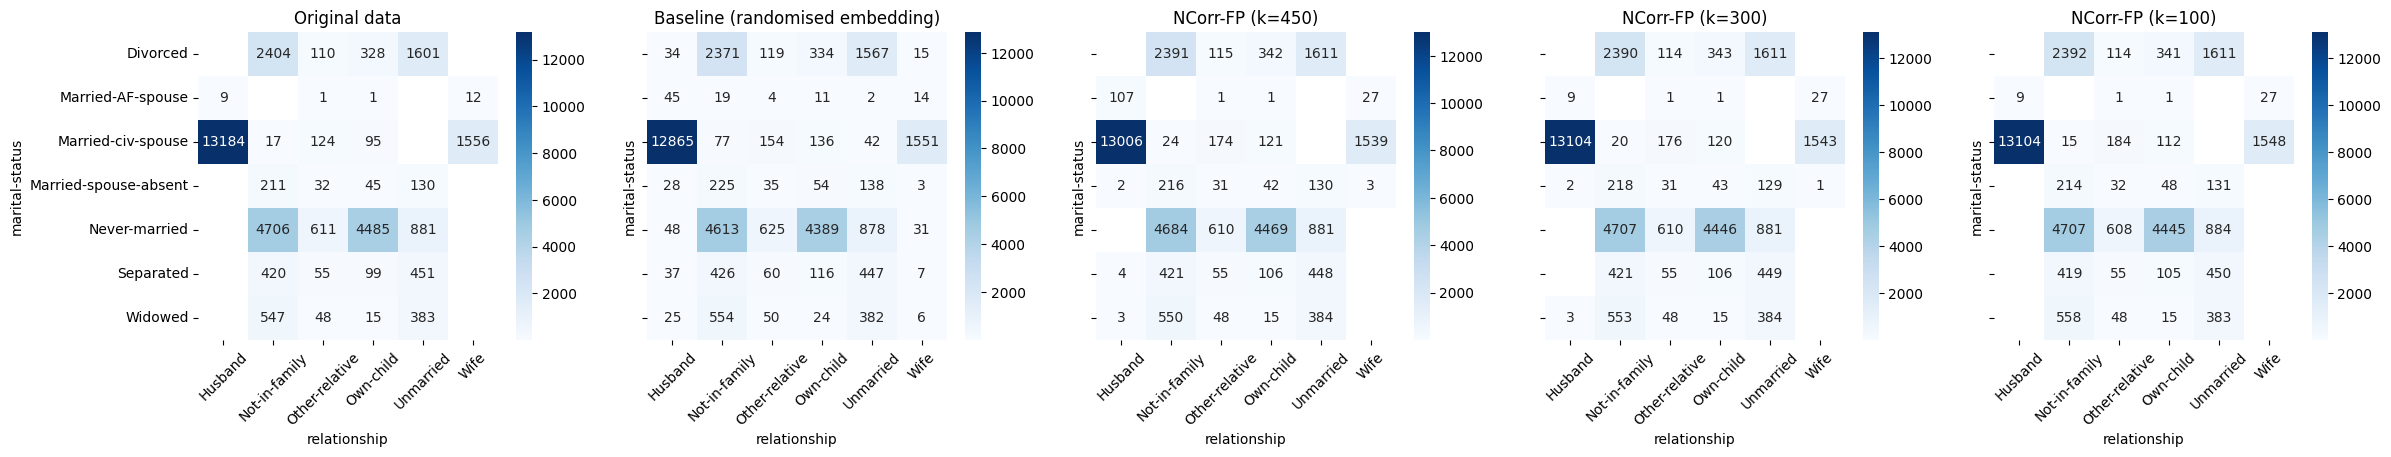

In [68]:
# pairwise histograms
# We investigate the pairwise attribute distributions of correlated attributes.
# E.g., relationship and marital status
fig, axs = plt.subplots(1, 5, figsize=(28,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# marital-status vs relationship
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in baseline.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('relationship')
axs[0].set_ylabel('marital-status')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_rand.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('relationship')
axs[1].set_ylabel('marital-status')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
axs[1].set_title('Baseline (randomised embedding)')

# NCorr 450
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_450.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('relationship')
axs[2].set_ylabel('marital-status')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)
axs[2].set_title('NCorr-FP (k=450)')

# NCorr k=300
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_300.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3])
axs[3].set_xlabel('relationship')
#axs[2].set_ylabel('marital-status')
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45)
axs[3].set_title('NCorr-FP (k=300)')


# NCorr 100
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_100.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[4])
axs[4].set_xlabel('relationship')
axs[4].set_ylabel('marital-status')
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=45)
axs[4].set_title('NCorr-FP (k=100)')

plt.savefig('../figures/pairwise_hist_adult_msr.png', dpi=300, bbox_inches='tight')

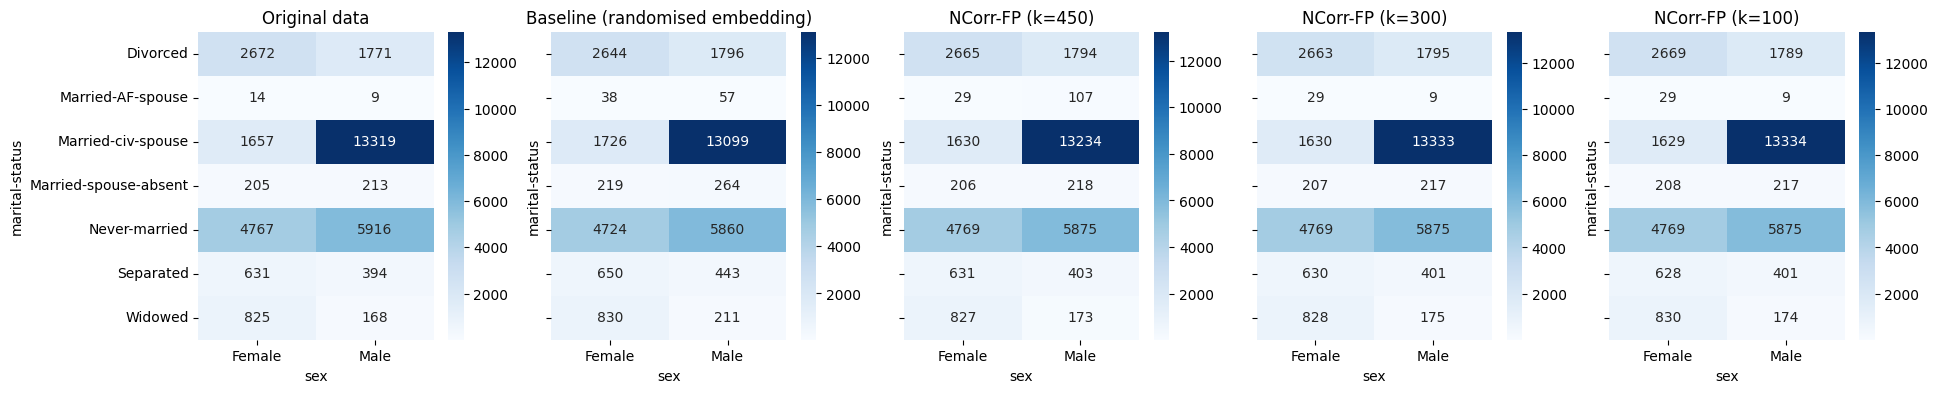

In [70]:
# pairwise histograms
# We investigate the pairwise attribute distributions of correlated attributes.
# E.g., sex and marital status
fig, axs = plt.subplots(1, 5, figsize=(22,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# marital-status vs sex
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in baseline.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('sex')
axs[0].set_ylabel('marital-status')
axs[0].set_xticklabels(axs[0].get_xticklabels())
axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_rand.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('sex')
axs[1].set_ylabel('marital-status')
axs[1].set_xticklabels(axs[1].get_xticklabels())
axs[1].set_title('Baseline (randomised embedding)')

# NCorr 450
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_450.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('sex')
axs[2].set_ylabel('marital-status')
axs[2].set_xticklabels(axs[2].get_xticklabels())
axs[2].set_title('NCorr-FP (k=450)')

# NCorr k=300
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_300.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3])
axs[3].set_xlabel('sex')
#axs[2].set_ylabel('marital-status')
axs[3].set_xticklabels(axs[3].get_xticklabels())
axs[3].set_title('NCorr-FP (k=300)')


# NCorr 100
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_100.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[4])
axs[4].set_xlabel('sex')
axs[4].set_ylabel('marital-status')
axs[4].set_xticklabels(axs[4].get_xticklabels())
axs[4].set_title('NCorr-FP (k=100)')

plt.savefig('../figures/pairwise_hist_adult_mss.png', dpi=300, bbox_inches='tight')

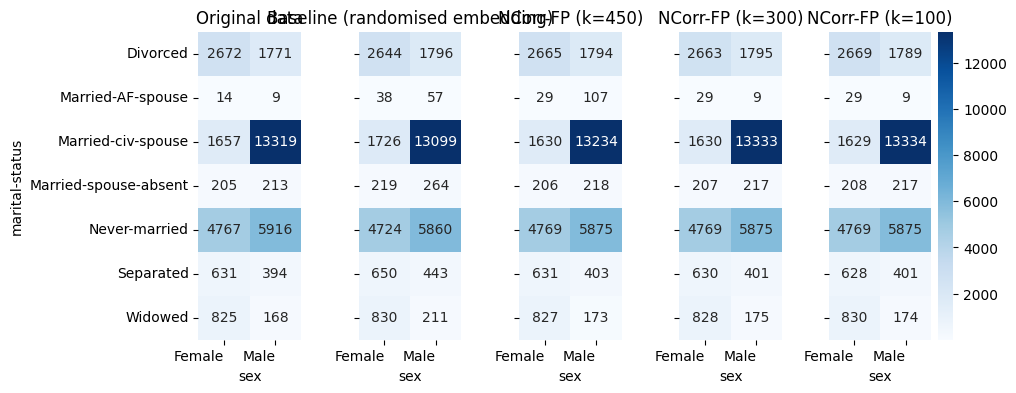

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up the figure
fig, axs = plt.subplots(1, 5, figsize=(10, 4), sharey=True)
axs = axs.flat

# Function to calculate aspect ratio for square cells
def set_square_aspect(ax, df_2dhist):
    n_rows, n_cols = df_2dhist.shape
    ax.set_aspect(n_cols*3 / n_rows)

# marital-status vs sex
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in baseline.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0], cbar=False)
axs[0].set_xlabel('sex')
axs[0].set_ylabel('marital-status')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0, ha='right')
axs[0].set_title('Original data')
set_square_aspect(axs[0], df_2dhist)

# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_rand.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1], cbar=False)
axs[1].set_xlabel('sex')
#axs[1].set_ylabel('marital-status')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0, ha='right')
axs[1].set_title('Baseline (randomised embedding)')
set_square_aspect(axs[1], df_2dhist)

# NCorr 450
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_450.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2], cbar=False)
axs[2].set_xlabel('sex')
#axs[2].set_ylabel('marital-status')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=0, ha='right')
axs[2].set_title('NCorr-FP (k=450)')
set_square_aspect(axs[2], df_2dhist)

# NCorr k=300
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_300.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3], cbar=False)
axs[3].set_xlabel('sex')
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=0, ha='right')
axs[3].set_title('NCorr-FP (k=300)')
set_square_aspect(axs[3], df_2dhist)

# NCorr 100
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_100.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[4]) #cbar=True, cbar_kws={'shrink': 0.8}
axs[4].set_xlabel('sex')
#axs[4].set_ylabel('marital-status')
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=0, ha='right')
axs[4].set_title('NCorr-FP (k=100)')
set_square_aspect(axs[4], df_2dhist)

# Save the figure
plt.savefig('../figures/pairwise_hist_adult_mss_squeezed.png', dpi=300, bbox_inches='tight')

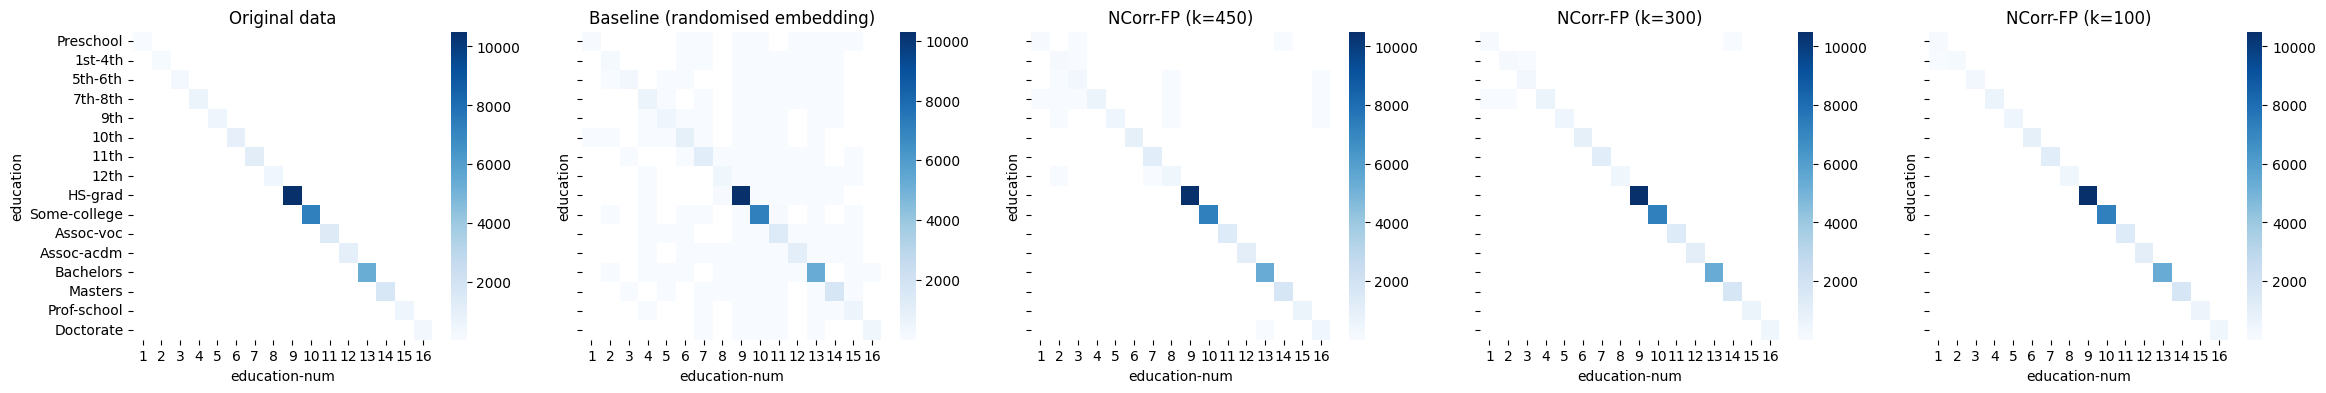

In [72]:
# pairwise histograms
# We investigate the pairwise attribute distributions of correlated attributes.
# E.g., relationship and marital status
fig, axs = plt.subplots(1, 5, figsize=(28, 4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')
y_axis_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 
                'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']


############
# ORIGINAL #
############
# education vs education-num
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in baseline.groupby('education-num')
})
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[0])
axs[0].set_xlabel('education-num')
axs[0].set_ylabel('education')
axs[0].set_xticklabels(axs[0].get_xticklabels())
axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in fp_data_rand.groupby('education-num')
})
df_2dhist = df_2dhist.iloc[:, :-1]
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[1])
axs[1].set_xlabel('education-num')
axs[1].set_ylabel('education')
axs[1].set_xticklabels(axs[1].get_xticklabels())
axs[1].set_title('Baseline (randomised embedding)')

# NCorr 450
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in fp_data_ncorr_450.groupby('education-num')
})
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[2])
axs[2].set_xlabel('education-num')
axs[2].set_ylabel('education')
axs[2].set_xticklabels(axs[2].get_xticklabels())
axs[2].set_title('NCorr-FP (k=450)')

# NCorr k=300
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in fp_data_ncorr_300.groupby('education-num')
})
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[3])
axs[3].set_xlabel('education-num')
#axs[2].set_ylabel('education')
axs[3].set_xticklabels(axs[3].get_xticklabels())
axs[3].set_title('NCorr-FP (k=300)')


# NCorr 100
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in fp_data_ncorr_100.groupby('education-num')
})
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[4])
axs[4].set_xlabel('education-num')
axs[4].set_ylabel('education')
axs[4].set_xticklabels(axs[4].get_xticklabels())
axs[4].set_title('NCorr-FP (k=100)')

plt.savefig('../figures/pairwise_hist_adult_een.png',  dpi=300, bbox_inches='tight')

In [56]:
data.correlated_attributes

[['sex', 'relationship', 'marital-status'], ['education', 'education-num']]

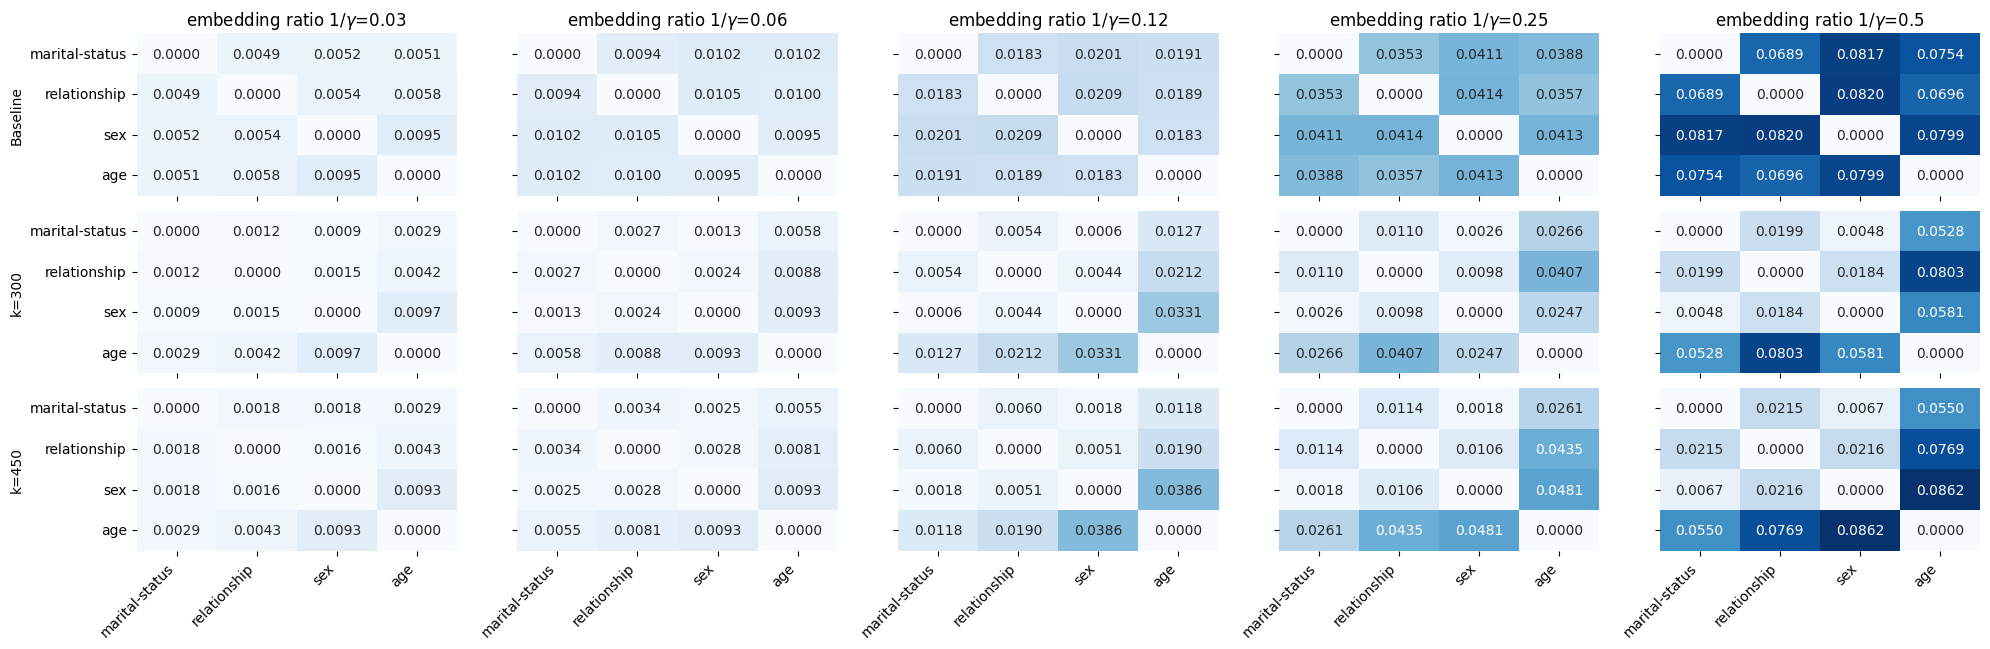

In [73]:
# imports for self-contained cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def correlation_heatmaps_plot(data_csv_path, baseline_csv_path, save=None):
    # Load main and baseline data
    df = pd.read_csv(data_csv_path)
    baseline_df = pd.read_csv(baseline_csv_path)

    # Filter data where fingerprint_length == 128
    df = df[df['fingerprint_length'] == 128]
    baseline_df = baseline_df[baseline_df['fingerprint_length'] == 128]

    # Extract relevant attributes and pairs
    attributes = ['marital-status', 'relationship', 'sex', 'age']
    relevant_pairs = [col for col in df.columns if any(attr in col for attr in attributes)]

    # Group main data and baseline data by embedding ratio
    group_data = df.groupby(['k', 'embedding_ratio'])[relevant_pairs].mean().reset_index()
    baseline_grouped = baseline_df.groupby(['embedding_ratio'])[relevant_pairs].mean().reset_index()

    # Generate heatmaps
    k_values = sorted(group_data['k'].unique())
    embedding_ratios = sorted(group_data['embedding_ratio'].unique())

    # Initialize a figure for the heatmaps
    fig, axes = plt.subplots(nrows=len(k_values) + 1, ncols=len(embedding_ratios),
                             figsize=(4 * len(embedding_ratios), 4 * (len(k_values) + 1)))
#    fig.suptitle("Average Correlation Difference Heatmaps with Baseline", fontsize=16, y=0.92)
    
#    plt.subplots_adjust(hspace=5)  # Increase vertical spacing between rows
    
    # Add the baseline row as the first row of heatmaps
    for j, embedding_ratio in enumerate(embedding_ratios):
        # Filter baseline data for the current embedding ratio
        subset = baseline_grouped[baseline_grouped['embedding_ratio'] == embedding_ratio]

        # Initialize an empty 4x4 matrix for the heatmap
        heatmap_matrix = pd.DataFrame(1, index=attributes, columns=attributes)  # Fill diagonal with 1s

        # Fill in the matrix with actual values
        for col in relevant_pairs:
            for row_attr in attributes:
                for col_attr in attributes:
                    if f"{row_attr}-{col_attr}" == col or f"{col_attr}-{row_attr}" == col:
                        heatmap_matrix.loc[row_attr, col_attr] = subset[col].values[0]

        # Diagonal cells to zero 
        heatmap_matrix = heatmap_matrix.replace(1, np.nan).fillna(0)

        # Plot the baseline heatmap
        ax = axes[0, j]
        sns.heatmap(heatmap_matrix, annot=True, fmt=".4f", cmap=sns.color_palette("Blues", as_cmap=True), cbar=False, ax=ax, vmin=0.0, vmax=0.087)

        ax.set_title(f"embedding ratio 1/$\gamma$={round(embedding_ratio, 2)}")
        ax.tick_params(left=True, bottom=True)
        plt.setp(ax.get_xticklabels(), visible=False)  # Hide x-tick labels for baseline row
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        # Only show y-ticks for the first column
        if j == 0:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            ax.set_ylabel("Baseline")
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

    # Iterate through each combination of k and embedding_ratio for NCorr-FP data
    for i, k in enumerate(k_values):
        for j, embedding_ratio in enumerate(embedding_ratios):
            # Filter main data for the current group
            subset = group_data[(group_data['k'] == k) & (group_data['embedding_ratio'] == embedding_ratio)]

            # Initialize an empty 4x4 matrix for the heatmap
            heatmap_matrix = pd.DataFrame(1, index=attributes, columns=attributes)  # Fill diagonal with 1s

            # Fill in the matrix with actual values
            for col in relevant_pairs:
                for row_attr in attributes:
                    for col_attr in attributes:
                        if f"{row_attr}-{col_attr}" == col or f"{col_attr}-{row_attr}" == col:
                            heatmap_matrix.loc[row_attr, col_attr] = subset[col].values[0]

            # Diagonal cells to zero
            heatmap_matrix = heatmap_matrix.replace(1, np.nan).fillna(0)

            # Plot the main heatmap
            ax = axes[i + 1, j]  # Offset by 1 for the baseline row
            sns.heatmap(heatmap_matrix, annot=True, fmt=".4f", cmap=sns.color_palette("Blues", as_cmap=True), cbar=False, ax=ax, 
                        vmin=0.0, vmax=0.087)

            #ax.set_title(f"embedding ratio 1/$\gamma$ ={round(embedding_ratio, 2)}")
            ax.tick_params(left=True, bottom=True)
            if i == len(k_values) - 1:  # Only show x-tick labels for the bottom row
                plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
            else:
                plt.setp(ax.get_xticklabels(), visible=False)  # Hide x-tick labels for other rows

            # Only show y-ticks for the first column
            if j == 0:
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
                ax.set_ylabel(f'k={k}')
            else:
                ax.set_yticklabels([])
                ax.set_ylabel("")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.55])  # reduce last parameter to squeeze the plots vertically
    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

data_csv_path = "results/fidelity_bivariate_adult.csv"
baseline_csv_path = "results/fidelity-baseline_bivariate_adult.csv"

correlation_heatmaps_plot(data_csv_path, baseline_csv_path, save='../figures/correlation_heatmaps_adult_squeezed.png')

## 3. Robustness

Robustness is measured by the resilience to the data modifications (attacks)
1. Independent attack: Robustness against flipping and subsetting attack
2. Independent attack: Background knowledge (maybe the correlation-knowing)
3. Collaboration attacks: Collusion on disagreeing values 
4. Collaboration attacks: Collusion with additional modifications

- Robustness stability: same attack, different fingerprinted datasets
- Robustness: same dataset, more randomised attacks

### 3.1 Collusions
Collusion attack is a vunerability of the fingerprinting methods because by cooprating, the recipients might obrtain data copies that do not carry traceable information anymore. 
There are a few things that affect robustness against the collusion such as the length of the fingerprint, the bit-wise difference of the fingerprints and the number of distributed datasets (the total number of recipients).

#### How do we resolve the collusions (accusation mechanism):
- We need a threshold that decides that the fingerpint does not come from a single source, say 95%, i.e. if less than 95% of bits are matching to a single recipient, we assume the collusion.
- Define Suspicion Scores: Assign a suspicion score to each user based on how much their code matches the detected fingerprint. The score is calculated by comparing each bit in the detected fingerprint to each user’s original code. If a bit in the detected fingerprint matches a bit in the user’s code, the user’s score increases.
- Weight the Matches Based on Probability: For each bit in the detected fingerprint, calculate the probability that this bit would have been contributed by a given user in the collusion. Use a scoring function where each matched bit contributes to a user's suspicion score, weighted by its probability.
- Use Log-Score Aggregation: log function is applied to the probability of each bit, which allows the suspicion scores to grow faster for users whose fingerprints align more closely with the detected fingerprint. For example, if the probability of user i contributing a particular bit is p_i, the log-suspicion score for user i based on bit b could be updated by adding log(p_i) or substracting log(1-p_i) if it doesn't.
- Set a Threshold for Detection - Calculate a threshold for the suspicion score, which may be based on the mean suspicion score plus a certain number of standard deviations. Users whose suspicion scores exceed this threshold are identified as potential colluders.

#### Collusion detection measures:
- **Precision (true positives)**: the number of correctly identified colluders relative to the total number of accusations. Ideally, this rate is 1.0 when all accused recipients are indeed the colluders. *Out of all the accused, how many are colluders?*
- **False accusation rate (false discovery rate)**: the number of innocent recipients accused relative to total accusations (1 - precision). This measure is ideally 0 when there are no innocent recipients accused. *Out of all the accused, how many are innocent?*
- **Recall** - the number of colluders accused relative to the total number of colluding partners. Recall is ideally 1.0, when all colluders are identified. *Out of all colluders, how many are detected?*

#### Colluders' strategies:
The colluders might take a number of paths in the way they attack. 
- hiding - the colluders want to confuse the detection algorithm by lowering the confidences of their fingerprints extraction
- framing - the colluders want to frame an innocent recipient 

These are the actions according to which we model the collusion attack:
- collusion by averaging: combine multiple datasets by taking the average/median of the disagreeing values
- collusion by substitution: combine multiple datasets by substituting disagreeing values with new ones
- collusion by substitution and random modification: collusion by substitution + flip random values where everyone agrees

In [3]:
import pandas as pd
collusion_results = pd.read_csv('results/robustness_collusion_adult.csv')

In [4]:
# Calculate the mean and std of hit_abs, false_accusation_rate, and recall
collusion_stats = collusion_results.groupby(['strategy', 'n_colluders', 'fingerprint_length', 'n_recipients', 'threshold'])[['hit_rate', 'false_accusation_rate', 'recall', 'total_accusations']].agg(['mean', 'std']).reset_index()

In [5]:
#collusion_stats = pd.read_csv('collusion-stats.csv').drop(0, axis=0)
collusion_stats

strategy n_colluders fingerprint_length n_recipients threshold  \
                                                                        
0           avg           2                 64           20         1   
1           avg           2                128           20         1   
2           avg           2                256           20         1   
3           avg           2                512           20         1   
4           avg           2               1024           20         1   
5           avg           3                 64           20         1   
6           avg           3                128           20         1   
7           avg           3                256           20         1   
8           avg           3                512           20         1   
9           avg           3               1024           20         1   
10          avg           5                 64           20         1   
11          avg           5                128           20         1   
12          avg           5                256           20         1   
13          avg           5                512           20         1   
14          avg           5               1024           20         1   
15          avg          10                 64           20         1   
16          avg          10                128           20         1   
17          avg          10                256           20         1   
18          avg          10                512           20         1   
19          avg          10               1024           20         1   
20       random           2                 64           20         1   
21       random           2                128           20         1   
22       random           2                256           20         1   
23       random           2                512           20         1   
24       random           2               1024           20         1   
25       random           3                 64           20         1   
26       random           3                128           20         1   
27       random           3                256           20         1   
28       random           3                512           20         1   
29       random           3               1024           20         1   
30       random           5                 64           20         1   
31       random           5                128           20         1   
32       random           5                256           20         1   
33       random           5                512           20         1   
34       random           5               1024           20         1   
35       random          10                 64           20         1   
36       random          10                128           20         1   
37       random          10                256           20         1   
38       random          10                512           20         1   
39       random          10               1024           20         1   
40  random_flip           2                 64           20         1   
41  random_flip           2                128           20         1   
42  random_flip           2                256           20         1   
43  random_flip           2                512           20         1   
44  random_flip           2               1024           20         1   
45  random_flip           3                 64           20         1   
46  random_flip           3                128           20         1   
47  random_flip           3                256           20         1   
48  random_flip           3                512           20         1   
49  random_flip           3               1024           20         1   
50  random_flip           5                 64           20         1   
51  random_flip           5                128           20         1   
52  random_flip           5                256           20      

In [6]:
collusion_stats.to_csv("results/collusion_adult_stats.csv", index=False)

#### Interpretation:
- strategy: collusion strategy (avg: averaging the differences, random: substituting the diffs, random_flip: substitute diffs and additionally modify values)
- n_colluders: number of colluding datasets
- fingerprint_length
- n_recipients: total number of distributed datasets
- threshold: decision parameters for accusation score cut-off 
- hit rate, false_accusation_rate and recall (mean, std): *see above*
- total_accusations: total number of detected colludes


The experiment show that collusion by substitution + additional flipping is the best strategy by the attackers, followed by the substitution alone, and averaging is the worse. A hypothesis is that the more successful techniques also decrease the data utility more.

Furthermore, hit rate and recall show good values for up to 3 colluders, but fail for larger collaborations. 

## 3.2. Single-user attacks
### 3.2.1 Horizontal subset

In [7]:
import pandas as pd
horizontal = pd.read_csv('results/robustness_horizontal_adult.csv')

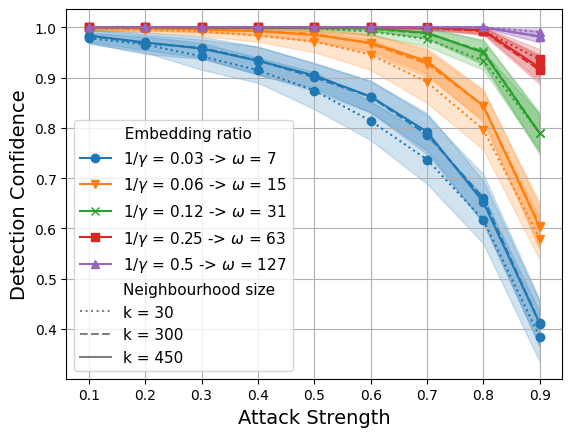

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Calculate mean and standard deviation for detection confidence grouped by 'k', 'embedding_ratio', and 'attack_strength'
grouped = horizontal.groupby(['k', 'embedding_ratio', 'attack_strength'])['detection_confidence'].agg(['mean', 'std']).reset_index()

# Setting up the plot
fig, ax = plt.subplots()

# Colors for different embedding ratios and line styles for different 'k'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {0.03125: colors[0], 0.0625: colors[1], 0.125: colors[2], 0.25: colors[3], 0.5: colors[4]}
line_styles = {30: ':', 300: '--', 450: '-'}
legend_handles = []

# Plotting each combination
for k in grouped['k'].unique():
    for i, embedding_ratio in enumerate(grouped['embedding_ratio'].unique()):
        subset = grouped[(grouped['k'] == k) & (grouped['embedding_ratio'] == embedding_ratio)]
        line, = ax.plot(subset['attack_strength'], subset['mean'], label=f'1/$\gamma$ = {round(embedding_ratio, 2)} -> $\omega$ = {int(embedding_ratio*32560/128)}',
                color=colors[embedding_ratio], linestyle=line_styles[k], marker=markers[i])
        ax.fill_between(subset['attack_strength'], subset['mean'] - subset['std'], subset['mean'] + subset['std'],
                        color=colors[embedding_ratio], alpha=0.2)
        # Adding legend entries only once for each unique k and embedding_ratio
        if k == max(grouped['k'].unique()):  
            legend_handles.append(line)

# Add an empty line to the legend for spacing
legend_handles.append(plt.Line2D([], [], linestyle='', label='Neighbourhood size'))
# Custom descriptions for line styles
for style, label in line_styles.items():
    line = plt.Line2D([], [], color='grey', linestyle=label, label=f'k = {style}')
    legend_handles.append(line)
    
ax.set_xlabel('Attack Strength', fontsize=14)
ax.set_ylabel('Detection Confidence', fontsize=14)
#ax.set_title('Detection Confidence by k, Embedding Ratio, and Attack Strength')
ax.legend(handles=legend_handles, title="  Embedding ratio", loc='best', fontsize=11, title_fontsize=11)
ax.grid()

plt.savefig('../figures/robustness_horizontal_adult.png', dpi=300, bbox_inches='tight')

plt.show()


In [15]:
# the table i can filter by best and worse case for brevity

import pandas as pd

# Load data from CSV (assuming the DataFrame is named df and data is loaded properly)
# df = pd.read_csv('path_to_your_csv.csv')

# List of attributes you specified
attributes = [
    'accuracy', 'hellinger_distance', 'kl_divergence',
    'marital-status_relationship']#, 'marital-status_sex', 'relationship_sex']#,
  #  'income_relationship', 'education_education-num', 'age_marital-status',
#    'education-num_occupation', 'age_relationship'
#]

# Grouping by 'embedding_ratio', 'k', and 'attack_strength' and calculating the mean
grouped = horizontal.groupby(['embedding_ratio', 'k', 'attack_strength'])[attributes].mean()

# Reset index to use columns in pivot_table
grouped_reset = grouped.reset_index()

# Pivot table to get attack strengths as columns, attributes as rows, indexed by embedding_ratio and k
pivot_table = pd.pivot_table(
    grouped_reset,
    values=attributes,
    index=['embedding_ratio', 'k'],
    columns='attack_strength',
    aggfunc='mean'
)

# Reorder the levels to have attributes as the top rows and attack_strength as sub-rows
pivot_table = pivot_table.stack(level='attack_strength').unstack(level=2).swaplevel(0, 1, axis=1).stack(level=1)#.sort_index(axis=1)
pivot_table.head(100)

attack_strength                                       0.1       0.2       0.3  \
embedding_ratio k                                                               
0.03125         30  accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.004114  0.006844  0.010004   
                    kl_divergence                0.000135  0.000376  0.000847   
                    marital-status_relationship  0.001038  0.001061  0.001115   
                300 accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.004678  0.007438  0.010604   
                    kl_divergence                0.000203  0.000480  0.000999   
                    marital-status_relationship  0.001049  0.001073  0.001093   
                450 accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.004802  0.007529  0.010663   
                    kl_divergence                0.000193  0.000466  0.000976   
                    marital-status_relationship  0.001591  0.001299  0.001180   
0.06250         30  accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.004779  0.007474  0.010616   
                    kl_divergence                0.000193  0.000466  0.000977   
                    marital-status_relationship  0.001389  0.001215  0.001284   
                300 accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.005909  0.008606  0.011735   
                    kl_divergence                0.000379  0.000715  0.001305   
                    marital-status_relationship  0.001491  0.001294  0.001292   
                450 accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.006268  0.008942  0.012033   
                    kl_divergence                0.000365  0.000695  0.001274   
                    marital-status_relationship  0.002673  0.002189  0.002274   
0.12500         30  accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.006116  0.008748  0.011820   
                    kl_divergence                0.000346  0.000680  0.001257   
                    marital-status_relationship  0.002659  0.002168  0.002266   
                300 accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.008358  0.010987  0.014047   
                    kl_divergence                0.000905  0.001365  0.002095   
                    marital-status_relationship  0.002992  0.002472  0.002542   
                450 accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.009103  0.011714  0.014730   
                    kl_divergence                0.000897  0.001351  0.002067   
                    marital-status_relationship  0.005039  0.004633  0.004653   
0.25000         30  accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.008985  0.011473  0.014414   
                    kl_divergence                0.000834  0.001264  0.001965   
                    marital-status_relationship  0.004759  0.004183  0.004254   
                300 accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.013158  0.015629  0.018498   
                    kl_divergence                0.002390  0.003033  0.003963   
                    marital-status_relationship  0.007855  0.007249  0.007263   
                450 accuracy                     0.900000  0.800000  0.700000   
                    hellinger_distance           0.014269  0.016697  0.019528   
                    kl_divergence                0.002398  0.003020  0.003938   
                    marital-sta

In [ ]:
#pivot_table.style.to_latex()

### 3.2.2 Vertical subset

In [16]:
vertical = pd.read_csv('results/robustness_vertical_adult.csv')

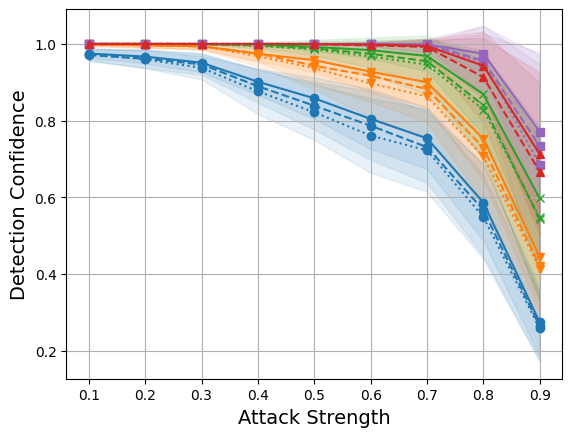

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate mean and standard deviation for detection confidence grouped by 'k', 'embedding_ratio', and 'attack_strength'
grouped = vertical.groupby(['k', 'embedding_ratio', 'attack_strength'])['detection_confidence'].agg(['mean', 'std']).reset_index()

# Setting up the plot
fig, ax = plt.subplots()#figsize=(9, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {0.03125: colors[0], 0.0625: colors[1], 0.125: colors[2], 0.25: colors[3], 0.5: colors[4]}
line_styles = {30: ':', 300: '--', 450: '-'}

# Plotting each combination
for k in grouped['k'].unique():
    for i, embedding_ratio in enumerate(grouped['embedding_ratio'].unique()):
        subset = grouped[(grouped['k'] == k) & (grouped['embedding_ratio'] == embedding_ratio)]
        ax.plot(subset['attack_strength'], subset['mean'], label=f'k={k}, ratio={embedding_ratio}',
                color=colors[embedding_ratio], linestyle=line_styles[k], marker=markers[i])
        ax.fill_between(subset['attack_strength'], subset['mean'] - subset['std'], subset['mean'] + subset['std'],
                        color=colors[embedding_ratio], alpha=0.1)

# Using legend from the previous plot

ax.set_xlabel('Attack Strength', fontsize=14)
ax.set_ylabel('Detection Confidence', fontsize=14)
#ax.set_title('Detection Confidence by k, Embedding Ratio, and Attack Strength')
#ax.legend(handles=legend_handles, title="    Embedding ratio", loc='best', fontsize=11, title_fontsize=11)
ax.grid()

plt.savefig('../figures/robustness_vertical_adult.png',  dpi=300, bbox_inches='tight')

plt.show()

In [18]:
# the table i can filter by best and worse case for brevity

import pandas as pd

# Load data from CSV (assuming the DataFrame is named df and data is loaded properly)
# df = pd.read_csv('path_to_your_csv.csv')

# List of attributes you specified
attributes = [
    'accuracy', 'hellinger_distance', 'hellinger_distance_remaining',
    'marital-status_relationship']#, 'marital-status_sex', 'relationship_sex']#,
  #  'income_relationship', 'education_education-num', 'age_marital-status',
#    'education-num_occupation', 'age_relationship'
#]

# Grouping by 'embedding_ratio', 'k', and 'attack_strength' and calculating the mean
grouped = vertical.groupby(['embedding_ratio', 'k', 'attack_strength'])[attributes].mean()

# Reset index to use columns in pivot_table
grouped_reset = grouped.reset_index()

# Pivot table to get attack strengths as columns, attributes as rows, indexed by embedding_ratio and k
pivot_table = pd.pivot_table(
    grouped_reset,
    values=attributes,
    index=['embedding_ratio', 'k'],
    columns='attack_strength',
    aggfunc='mean'
)

# Reorder the levels to have attributes as the top rows and attack_strength as sub-rows
pivot_table = pivot_table.stack(level='attack_strength').unstack(level=2).swaplevel(0, 1, axis=1).stack(level=1)#.sort_index(axis=1)
pivot_table

attack_strength                                        0.1       0.2  \
embedding_ratio k                                                      
0.03125         30  accuracy                      0.875000  0.812500   
                    hellinger_distance            0.134166  0.200725   
                    hellinger_distance_remaining  0.000961  0.000906   
                    marital-status_relationship   0.000712  0.000733   
                300 accuracy                      0.875000  0.812500   
                    hellinger_distance            0.134745  0.201183   
                    hellinger_distance_remaining  0.001629  0.001479   
                    marital-status_relationship   0.000817  0.000833   
                450 accuracy                      0.875000  0.812500   
                    hellinger_distance            0.134966  0.201369   
                    hellinger_distance_remaining  0.001884  0.001711   
                    marital-status_relationship   0.001528  0.001525   
0.06250         30  accuracy                      0.875000  0.812500   
                    hellinger_distance            0.134921  0.201380   
                    hellinger_distance_remaining  0.001831  0.001725   
                    marital-status_relationship   0.001195  0.001263   
                300 accuracy                      0.875000  0.812500   
                    hellinger_distance            0.136006  0.202243   
                    hellinger_distance_remaining  0.003084  0.002803   
                    marital-status_relationship   0.001349  0.001391   
                450 accuracy                      0.875000  0.812500   
                    hellinger_distance            0.136461  0.202627   
                    hellinger_distance_remaining  0.003609  0.003284   
                    marital-status_relationship   0.002668  0.002712   
0.12500         30  accuracy                      0.875000  0.812500   
                    hellinger_distance            0.136269  0.202555   
                    hellinger_distance_remaining  0.003388  0.003194   
                    marital-status_relationship   0.002663  0.002773   
                300 accuracy                      0.875000  0.812500   
                    hellinger_distance            0.138347  0.204193   
                    hellinger_distance_remaining  0.005785  0.005241   
                    marital-status_relationship   0.003007  0.003071   
                450 accuracy                      0.875000  0.812500   
                    hellinger_distance            0.139167  0.204905   
                    hellinger_distance_remaining  0.006732  0.006131   
                    marital-status_relationship   0.005020  0.005109   
0.25000         300 accuracy                      0.875000  0.812500   
                    hellinger_distance            0.142841  0.208023   
                    hellinger_distance_remaining  0.010971  0.010029   
                    marital-status_relationship   0.007961  0.008177   
                450 accuracy                      0.875000  0.812500   
                    hellinger_distance            0.143982  0.209002   
                    hellinger_distance_remaining  0.012286  0.011253   
                    marital-status_relationship   0.009159  0.009219   
0.50000         30  accuracy                      0.875000  0.812500   
                    hellinger_distance            0.143908  0.209123   
                    hellinger_distance_remaining  0.012201  0.011403   
                    marital-status_relationship   0.008836  0.008892   
                300 accuracy                      0.875000  0.812500   
                    hellinger_distance            0.150779  0.214743   
                    hellinger_distance_remaining  0.020129  0.018429   
                    marital-status_relationship   0.020094  0.020167   
                450 accuracy                      0.875000  0.812500   
                    hellinger_distance  

### 3.2.3. Flipping attack

In [19]:
flipping = pd.read_csv('results/robustness_flipping_adult.csv')

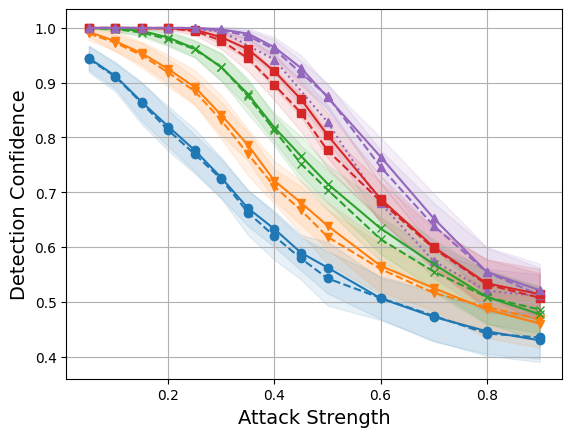

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Calculate mean and standard deviation for detection confidence grouped by 'k', 'embedding_ratio', and 'attack_strength'
grouped = flipping.groupby(['k', 'embedding_ratio', 'attack_strength'])['detection_confidence'].agg(['mean', 'std']).reset_index()

# Setting up the plot
fig, ax = plt.subplots()

# Colors for different embedding ratios and line styles for different 'k'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {0.03125: colors[0], 0.0625: colors[1], 0.125: colors[2], 0.25: colors[3], 0.5: colors[4]}
line_styles = {30: ':', 300: '--', 450: '-'}
legend_handles = []

# Plotting each combination
for k in grouped['k'].unique():
    for i, embedding_ratio in enumerate(sorted(grouped['embedding_ratio'].unique())):
        subset = grouped[(grouped['k'] == k) & (grouped['embedding_ratio'] == embedding_ratio)]
        line, = ax.plot(subset['attack_strength'], subset['mean'], label=f'1/$\gamma$ = {round(embedding_ratio, 2)} -> $\omega$ = {int(embedding_ratio*32560/128)}',
                color=colors[embedding_ratio], linestyle=line_styles[k], marker=markers[i])
        ax.fill_between(subset['attack_strength'], subset['mean'] - subset['std'], subset['mean'] + subset['std'],
                        color=colors[embedding_ratio], alpha=0.1)
        # Adding legend entries only once for each unique k and embedding_ratio
        if k == max(grouped['k'].unique()):  
            legend_handles.append(line)

# Add an empty line to the legend for spacing
legend_handles.append(plt.Line2D([], [], linestyle='', label='Neighbourhood size'))
# Custom descriptions for line styles
for style, label in line_styles.items():
    line = plt.Line2D([], [], color='grey', linestyle=label, label=f'k = {style}')
    legend_handles.append(line)

ax.set_xlabel('Attack Strength', fontsize=14)
ax.set_ylabel('Detection Confidence', fontsize=14)
#ax.set_title('Detection Confidence by k, Embedding Ratio, and Attack Strength')
#ax.legend(handles=legend_handles, title="    Embedding ratio", loc='best', fontsize=11, title_fontsize=11)
ax.grid()
plt.savefig('../figures/robustness_flipping_adult.png',  dpi=300, bbox_inches='tight')

plt.show()

In [22]:
# the table i can filter by best and worse case for brevity

import pandas as pd

# Load data from CSV (assuming the DataFrame is named df and data is loaded properly)
# df = pd.read_csv('path_to_your_csv.csv')

# List of attributes you specified
attributes = [
    'accuracy', 'hellinger_distance', 'kl_divergence',
    'marital-status_relationship']#, 'marital-status_sex', 'relationship_sex']#,
  #  'income_relationship', 'education_education-num', 'age_marital-status',
#    'education-num_occupation', 'age_relationship'
#]

# Grouping by 'embedding_ratio', 'k', and 'attack_strength' and calculating the mean
grouped = flipping.groupby(['embedding_ratio', 'k', 'attack_strength'])[attributes].mean()

# Reset index to use columns in pivot_table
grouped_reset = grouped.reset_index()

# Pivot table to get attack strengths as columns, attributes as rows, indexed by embedding_ratio and k
pivot_table = pd.pivot_table(
    grouped_reset,
    values=attributes,
    index=['embedding_ratio', 'k'],
    columns='attack_strength',
    aggfunc='mean'
)

# Reorder the levels to have attributes as the top rows and attack_strength as sub-rows
pivot_table = pivot_table.stack(level='attack_strength').unstack(level=2).swaplevel(0, 1, axis=1).stack(level=1)#.sort_index(axis=1)
pivot_table

attack_strength                                      0.05      0.10      0.15  \
embedding_ratio k                                                               
0.03125         300 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.050749  0.084867  0.113557   
                    kl_divergence                0.014699  0.037012  0.062106   
                    marital-status_relationship  0.110785  0.209605  0.299828   
                450 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.050761  0.084863  0.113545   
                    kl_divergence                0.014699  0.036984  0.062078   
                    marital-status_relationship  0.110991  0.209803  0.300021   
0.06250         300 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.051493  0.085438  0.114041   
                    kl_divergence                0.015145  0.037536  0.062715   
                    marital-status_relationship  0.111567  0.210447  0.300522   
                450 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.051571  0.085518  0.114058   
                    kl_divergence                0.015163  0.037576  0.062697   
                    marital-status_relationship  0.112012  0.210851  0.300876   
0.12500         300 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.053077  0.086714  0.115037   
                    kl_divergence                0.016214  0.038790  0.063971   
                    marital-status_relationship  0.113354  0.212019  0.301890   
                450 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.053289  0.086859  0.115150   
                    kl_divergence                0.016255  0.038842  0.064027   
                    marital-status_relationship  0.114078  0.212708  0.302546   
0.25000         300 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.056155  0.089052  0.116867   
                    kl_divergence                0.018534  0.041243  0.066383   
                    marital-status_relationship  0.117498  0.215504  0.305159   
                450 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.056488  0.089299  0.117076   
                    kl_divergence                0.018535  0.041265  0.066432   
                    marital-status_relationship  0.117788  0.215983  0.305656   
0.50000         30  accuracy                          NaN  0.900000       NaN   
                    hellinger_distance                NaN  0.089356       NaN   
                    kl_divergence                     NaN  0.041390       NaN   
                    marital-status_relationship       NaN  0.218864       NaN   
                300 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.061753  0.093465  0.120479   
                    kl_divergence                0.023510  0.046303  0.071426   
                    marital-status_relationship  0.127151  0.224089  0.312957   
                450 accuracy                     0.950000  0.900000  0.850000   
                    hellinger_distance           0.062100  0.093686  0.120650   
                    kl_divergence                0.023319  0.046112  0.071252   
                    marital-status_relationship  0.128907  0.225932  0.314807   

attack_strength                                      0.20      0.25      0.30  \
embedding_ratio k                                                               
0.03125         300 accuracy                     0.800000  0.750000  0.700000   
                    hellinger_

In [13]:
#pivot_table.style.to_latex()

### 3.2.4. Cluster flipping attack

For the cluster-based attacks, the intuition is that the attacker tries to remove or modify the what could be the most influential records in neighbourhoods' creation, hoping that this way the neighbourhood creation will fail. 
Since the attacker models assume the open system, i.e. the fingerprinting algorithms are available, the attacker uses it to create their own neighbourhoods and record the most influential records. Although the fingerprinting parameters are not explicitly available, the attack may use the parameter recommendations to try to be close to the original choices.
Regardless of the non-transparency of the parameter choice, we run the experiments with the exact parameter settings to evaluate the influence of the secret key on robustness.

With the data-driven approach of NCorrFP we open a new potential attack vector - the goal of this evaluation is to estimate the risks of fingerprint removal due to this attack vector.

In [24]:
import pandas as pd
flipping = pd.read_csv('results/robustness_flipping_adult.csv')
cluster_flipping = pd.read_csv('results/robustness_clusterflipping_adult.csv')
cluster_flipping_exact_param = pd.read_csv('results/robustness_clusterflippingexactparam_adult.csv') 

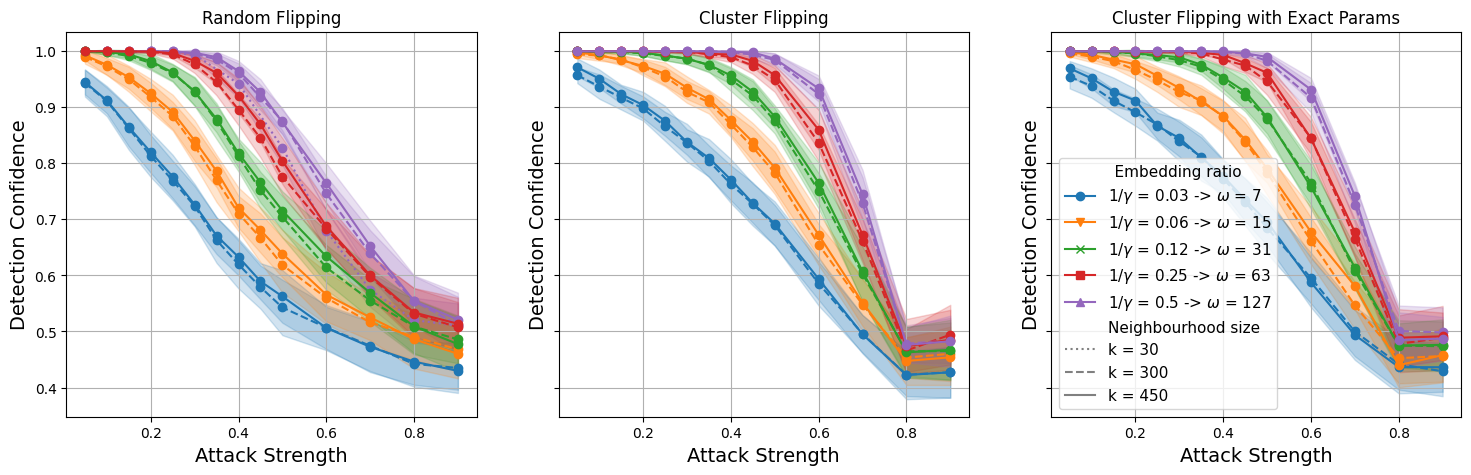

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Setup for plotting
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(18, 5))  # Create two subplots sharing y axis

# Colors and styles setup
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_map = {0.03125: colors[0], 0.0625: colors[1], 0.125: colors[2], 0.25: colors[3], 0.5: colors[4]}
line_styles = {30:':', 300: '--', 450: '-'}

# Plot function
def plot_data(ax, data, title=None, legend=False):
    grouped = data.groupby(['k', 'embedding_ratio', 'attack_strength'])['detection_confidence'].agg(['mean', 'std']).reset_index()
    for k in grouped['k'].unique():
        for embedding_ratio in grouped['embedding_ratio'].unique():
            subset = grouped[(grouped['k'] == k) & (grouped['embedding_ratio'] == embedding_ratio)]
            ax.plot(subset['attack_strength'], subset['mean'], label=f'1/$\gamma$ = {embedding_ratio}',
                    color=color_map[embedding_ratio], linestyle=line_styles[k], marker='o')
            ax.fill_between(subset['attack_strength'], subset['mean'] - subset['std'], subset['mean'] + subset['std'],
                            color=color_map[embedding_ratio], alpha=0.2)
    ax.set_xlabel('Attack Strength', fontsize=14)
    ax.set_ylabel('Detection Confidence', fontsize=14)
    if title is not None:
        ax.set_title(title)
    if legend:
        ax.legend(handles=legend_handles, title="    Embedding ratio", loc='best', fontsize=11, title_fontsize=11)
    ax.grid(True)
# plot the random flipping
# todo: plot further attack strengths 
#plot_data(axes[0], flipping[flipping['attack_strength'] <= 0.5], 'Random Flipping')
plot_data(axes[0], flipping, 'Random Flipping')

# Plotting for cluster_flipping data
plot_data(axes[1], cluster_flipping, 'Cluster Flipping')

# Plotting for other data
plot_data(axes[2], cluster_flipping_exact_param, 'Cluster Flipping with Exact Params')  
axes[2].legend(handles=legend_handles, title="    Embedding ratio", loc='best', fontsize=11, title_fontsize=11)


# Handling legend: only on the first plot
handles, labels = axes[0].get_legend_handles_labels()
#fig.legend(handles=handles, title="    Embedding ratio", loc='best', fontsize=8, title_fontsize=8)
#fig.legend(handles, labels, ncol=len(labels))

#plt.tight_layout()
plt.savefig('../figures/robustness_flipping_all.png', dpi=300, bbox_inches='tight')
plt.show()

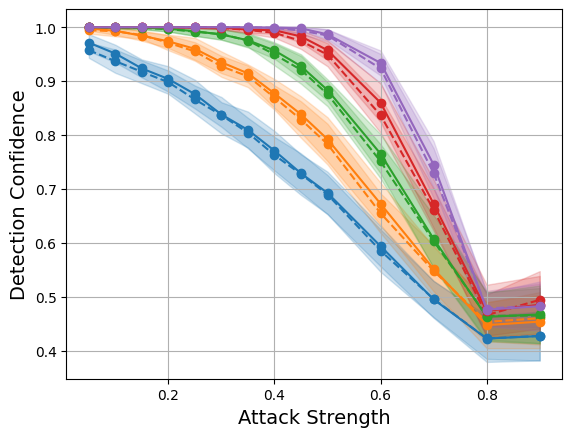

In [26]:
# one by one
fig, axes = plt.subplots(1, 1, sharey=True, sharex=True)  # Create two subplots sharing y axis
plot_data(axes, cluster_flipping, legend=False)
plt.savefig('../figures/robustness_clusterflipping_adult.png', dpi=300, bbox_inches='tight')

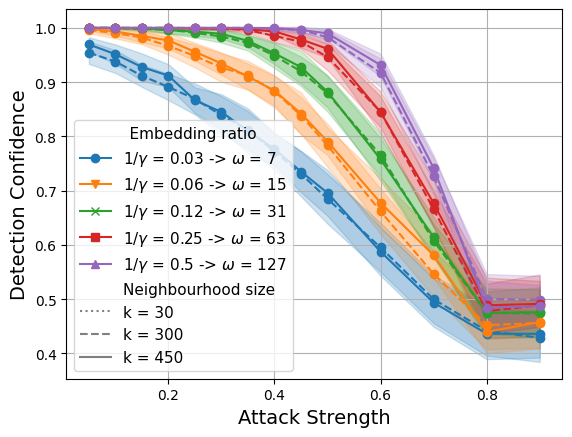

In [27]:
# one by one
fig, axes = plt.subplots(1, 1, sharey=True, sharex=True)  # Create two subplots sharing y axis
plot_data(axes, cluster_flipping_exact_param, legend=True)
plt.savefig('../figures/robustness_clusterflippingep_adult.png', dpi=300, bbox_inches='tight')

Selecting influential records and flipping this selection does not seem to overperform a random attacker, nor does knowing the exact fingerprint parameters. The distributions in the neighbourhoods seem therefore stable enough to run a correct detection even if more directed modifications are done on the data.

## 4. Utility

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [32]:
utility_data = pd.read_csv('results/utility_adult.csv')
score_data = pd.read_csv('utility/scores.csv')

# Group by 'gamma' and 'neighbourhood size' to calculate mean and standard deviation
#grouped_data = results.groupby(['gamma', 'k'])['vote_error'].agg(['mean', 'std']).reset_index()
utility_data['embedding_ratio'] = 1/utility_data['gamma']
# Plotting

markers = ['o', 'v', 'x', 's', "^", "*", "P", "1", "X", "p", "D"]
line_styles = {300: '-', 450: '--'}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'XGBoost': colors[0], 'RandomForest': colors[1], 'MLP': colors[2], 'LogisticRegression': colors[3], 'GradientBoosting': colors[4]}
utility_data.head()

,model,gamma,k,fp_len,score_avg,score_std,embedding_ratio
0,XGBoost,2,300,128,0.854323,0.000582,0.50
1,XGBoost,2,450,128,0.854864,0.000877,0.50
2,MLP,2,300,128,0.842394,0.000650,0.50
3,MLP,2,450,128,0.841872,0.000916,0.50
4,XGBoost,4,300,128,0.856927,0.000524,0.25


      model  gamma    k  fp_len  score_avg  score_std  embedding_ratio
0   XGBoost      2  300     128   0.854323   0.000582          0.50000
4   XGBoost      4  300     128   0.856927   0.000524          0.25000
8   XGBoost      8  300     128   0.858196   0.000374          0.12500
12  XGBoost     16  300     128   0.859037   0.000347          0.06250
16  XGBoost     32  300     128   0.859814   0.000382          0.03125
   model  gamma    k  fp_len  score_avg  score_std  embedding_ratio
2    MLP      2  300     128   0.842394   0.000650          0.50000
6    MLP      4  300     128   0.844514   0.000715          0.25000
11   MLP      8  300     128   0.847109   0.000804          0.12500
15   MLP     16  300     128   0.848383   0.000744          0.06250
19   MLP     32  300     128   0.849854   0.000974          0.03125
                 model  gamma    k  fp_len  score_avg  score_std  \
20  LogisticRegression      2  300     128   0.808418   0.000482   
21  LogisticRegression      4 

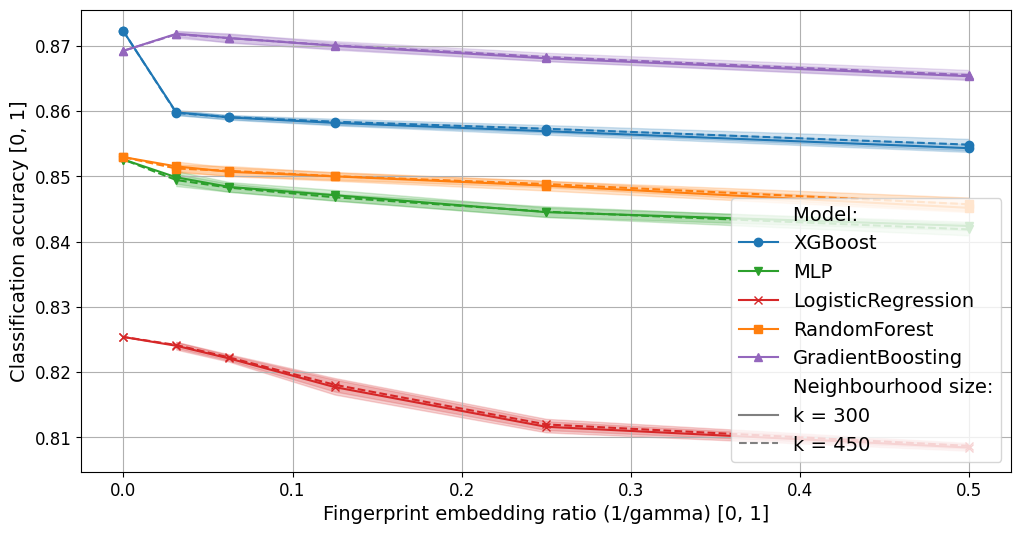

In [36]:
# Iterate through each neighborhood size for separate lines and shaded areas
fig, axes = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(12,6)) 
legend_handles = []

for i, neighborhood_size in enumerate(utility_data['k'].unique()):
    for j, model in enumerate(utility_data['model'].unique()):
        # if model == 'GradientBoosting':
        #     continue
        subset = utility_data[(utility_data['k'] == neighborhood_size) & (utility_data['model'] == model)]
        print(subset)
        y = np.append(subset['score_avg'], score_data[score_data['model']==model]['score'])
        line, = axes.plot(np.append(subset['embedding_ratio'], 0), y,
                            label=f'{model}', color=colors[model],
                            linestyle=line_styles[neighborhood_size], marker=markers[j])
        #        axes.vlines(subset['embedding_ratio'], subset['score_avg'] - subset['score_std'], subset['score_avg'] + subset['score_std'], 
        #                    color=color_map[model], linestyle='solid', alpha=0.2)
        # Plot shaded area for standard deviation
        # if model not in ['RandomForest']:  # random forest std is so much
        plt.fill_between(subset['embedding_ratio'], subset['score_avg'] - subset['score_std'], subset['score_avg'] + subset['score_std'], alpha=0.2, 
                    color=colors[model])
        if neighborhood_size == min(utility_data['k'].unique()):  
            legend_handles.append(line)

legend_handles.append(plt.Line2D([], [], linestyle='', label='Neighbourhood size:'))
# Custom descriptions for line styles
for style, label in line_styles.items():
    line = plt.Line2D([], [], color='grey', linestyle=label, label=f'k = {style}')
    legend_handles.append(line)
# plt.ylim(0, 1)
# Labels and legend
axes.set_xlabel('Fingerprint embedding ratio (1/gamma) [0, 1]', fontsize=14)
axes.set_ylabel('Classification accuracy [0, 1]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#axes.set_title('Vote Error Rate vs Fingerprint embedding ratio with Neighborhood Size')
axes.legend(handles=legend_handles, title='Model:             ', loc='lower right', fontsize=14, title_fontsize=14)
axes.grid(True)

plt.savefig('../figures/utility.png', dpi=300, bbox_inches='tight')